# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_and_log"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_log/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.008541,0.009541,-0.895208,0.370709,0.814645,random.pheno988
1,LV2,0.026481,0.012455,2.126108,0.033532,0.016766,random.pheno988
2,LV3,-0.012984,0.012274,-1.057802,0.290186,0.854907,random.pheno988
3,LV4,-0.016080,0.011922,-1.348766,0.177459,0.911270,random.pheno988
4,LV5,0.004920,0.012742,0.386126,0.699416,0.349708,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06452786220871327

# QQ-plot

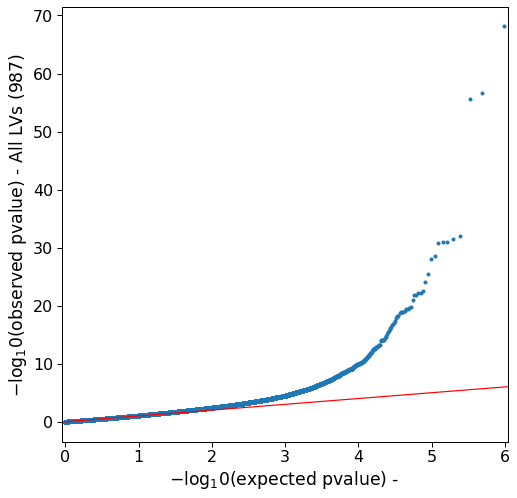

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.029,0.074
1,LV10,0.008,0.049,0.088
2,LV100,0.010,0.031,0.063
3,LV101,0.005,0.040,0.078
4,LV102,0.016,0.062,0.105


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.019363,0.064528,0.114133
std,0.018377,0.029524,0.037710
min,0.000000,0.000000,0.000000
25%,0.011000,0.049000,0.093000
50%,0.016000,0.061000,0.110000
75%,0.022000,0.073000,0.129000
max,0.257000,0.353000,0.412000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(55, 4)

,lv,1,5,10
1,LV10,0.008,0.049,0.088
314,LV382,0.010,0.049,0.096
258,LV331,0.012,0.049,0.091
363,LV426,0.016,0.049,0.095
227,LV303,0.009,0.049,0.097
364,LV427,0.012,0.049,0.100
395,LV455,0.011,0.049,0.086
406,LV465,0.010,0.049,0.085
755,LV78,0.016,0.049,0.087
294,LV364,0.014,0.049,0.097


,lv,1,5,10
825,LV842,0.009,0.051,0.091
893,LV903,0.010,0.051,0.097
648,LV683,0.012,0.051,0.095
644,LV68,0.015,0.051,0.092
397,LV457,0.010,0.051,0.095
592,LV632,0.018,0.051,0.098
490,LV540,0.017,0.051,0.097
424,LV481,0.012,0.051,0.089
313,LV381,0.016,0.051,0.091
293,LV363,0.016,0.051,0.095


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(496, 4)

,lv,1,5,10
743,LV769,0.054,0.154,0.233
129,LV215,0.079,0.172,0.236
349,LV413,0.104,0.176,0.228
153,LV237,0.091,0.177,0.253
423,LV480,0.090,0.178,0.260
255,LV329,0.135,0.183,0.211
965,LV969,0.108,0.188,0.264
682,LV713,0.109,0.195,0.250
401,LV460,0.112,0.196,0.256
549,LV594,0.122,0.198,0.249


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017062,0.010313,1.654453,0.098084,0.049042,random.pheno988
1031,LV45,0.010840,0.010322,1.050148,0.293689,0.146845,random.pheno589
2018,LV45,0.004870,0.010320,0.471914,0.637004,0.318502,random.pheno385
3005,LV45,0.006269,0.010311,0.607984,0.543219,0.271610,random.pheno5
3992,LV45,-0.016458,0.010308,-1.596721,0.110377,0.944812,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.021

In [32]:
show_prop(results, 0.05)

0.064

In [33]:
show_prop(results, 0.10)

0.124

In [34]:
show_prop(results, 0.15)

0.163

In [35]:
show_prop(results, 0.20)

0.202

### QQplot

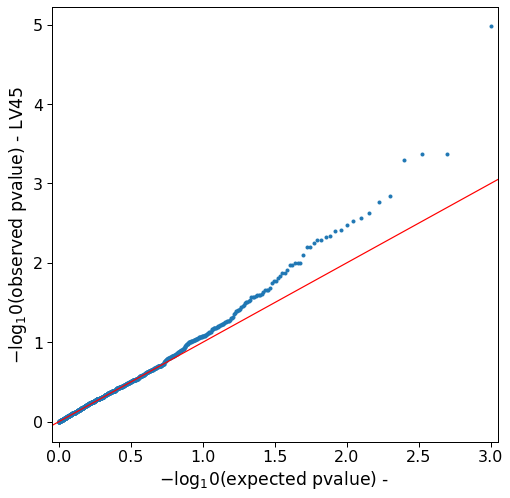

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.020256,0.012354,1.639636,0.101130,0.050565,random.pheno988
1220,LV234,0.000539,0.012344,0.043693,0.965151,0.482575,random.pheno589
2207,LV234,-0.012608,0.012337,-1.021970,0.306834,0.846583,random.pheno385
3194,LV234,0.009900,0.012339,0.802321,0.422397,0.211199,random.pheno5
4181,LV234,0.002506,0.012367,0.202640,0.839422,0.419711,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.018

In [43]:
show_prop(results, 0.05)

0.062

In [44]:
show_prop(results, 0.10)

0.118

In [45]:
show_prop(results, 0.15)

0.151

In [46]:
show_prop(results, 0.20)

0.179

### QQplot

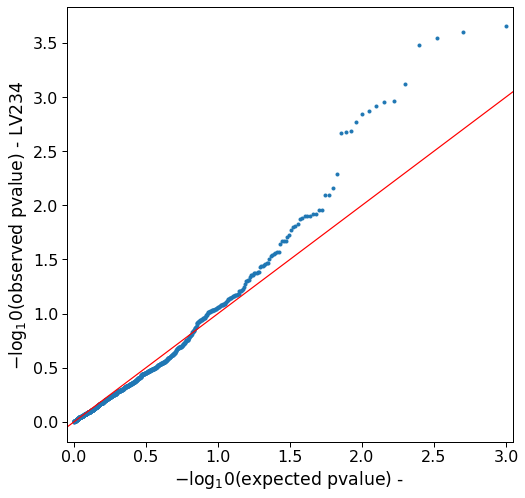

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.009442,0.012900,0.731968,0.464215,0.232107,random.pheno988
1833,LV847,0.003520,0.012926,0.272328,0.785378,0.392689,random.pheno589
2820,LV847,-0.014903,0.012908,-1.154534,0.248324,0.875838,random.pheno385
3807,LV847,0.008200,0.012894,0.635967,0.524820,0.262410,random.pheno5
4794,LV847,0.007459,0.012946,0.576175,0.564517,0.282259,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.025

In [54]:
show_prop(results, 0.05)

0.062

In [55]:
show_prop(results, 0.10)

0.104

In [56]:
show_prop(results, 0.15)

0.144

In [57]:
show_prop(results, 0.20)

0.189

### QQplot

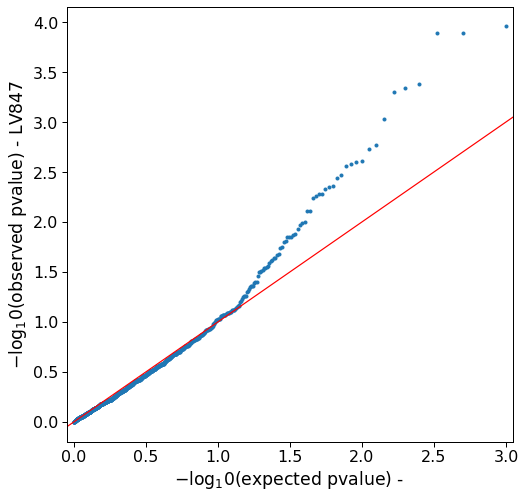

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.020411,0.013594,-1.501455,0.133287,0.933357,random.pheno988
1096,LV110,-0.007683,0.013607,-0.564650,0.572332,0.713834,random.pheno589
2083,LV110,-0.022321,0.013596,-1.641697,0.100702,0.949649,random.pheno385
3070,LV110,-0.009416,0.013558,-0.694445,0.487428,0.756286,random.pheno5
4057,LV110,-0.000623,0.013599,-0.045807,0.963465,0.518267,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.009

In [65]:
show_prop(results, 0.05)

0.037

In [66]:
show_prop(results, 0.10)

0.078

In [67]:
show_prop(results, 0.15)

0.119

In [68]:
show_prop(results, 0.20)

0.158

### QQplot

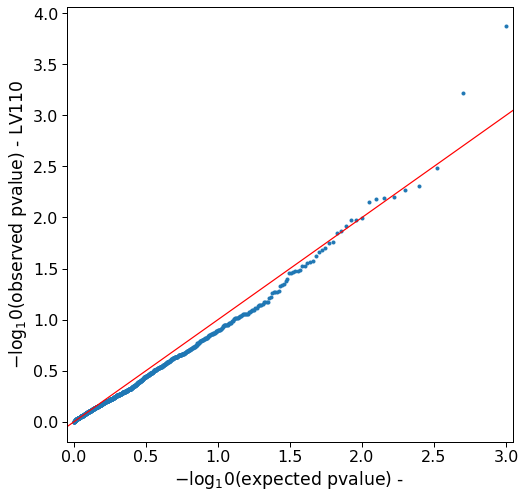

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.016530,0.011853,1.394579,0.163191,0.081596,random.pheno988
1755,LV769,0.001945,0.011820,0.164529,0.869320,0.434660,random.pheno589
2742,LV769,0.003684,0.011838,0.311165,0.755685,0.377843,random.pheno385
3729,LV769,-0.014222,0.011835,-1.201624,0.229553,0.885223,random.pheno5
4716,LV769,-0.018885,0.011859,-1.592439,0.111335,0.944332,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.054

In [76]:
show_prop(results, 0.05)

0.154

In [77]:
show_prop(results, 0.10)

0.233

In [78]:
show_prop(results, 0.15)

0.301

In [79]:
show_prop(results, 0.20)

0.359

### QQplot

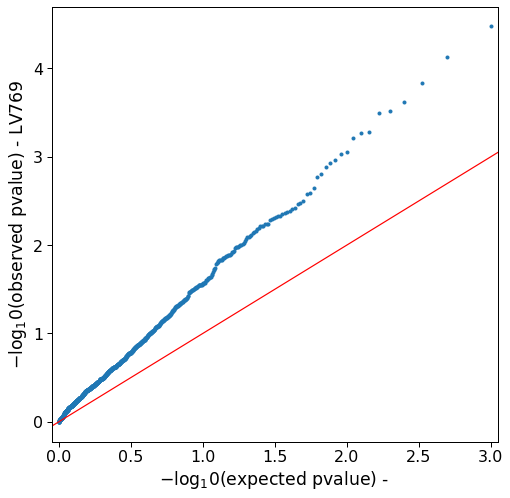

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.008228,0.014062,0.585141,0.558473,0.279237,random.pheno988
1786,LV800,-0.006942,0.014070,-0.493386,0.621757,0.689122,random.pheno589
2773,LV800,-0.001393,0.014091,-0.098891,0.921228,0.539386,random.pheno385
3760,LV800,-0.021765,0.014100,-1.543602,0.122734,0.938633,random.pheno5
4747,LV800,-0.010776,0.014041,-0.767473,0.442828,0.778586,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.053

In [88]:
show_prop(results, 0.10)

0.098

In [89]:
show_prop(results, 0.15)

0.143

In [90]:
show_prop(results, 0.20)

0.19

### QQplot

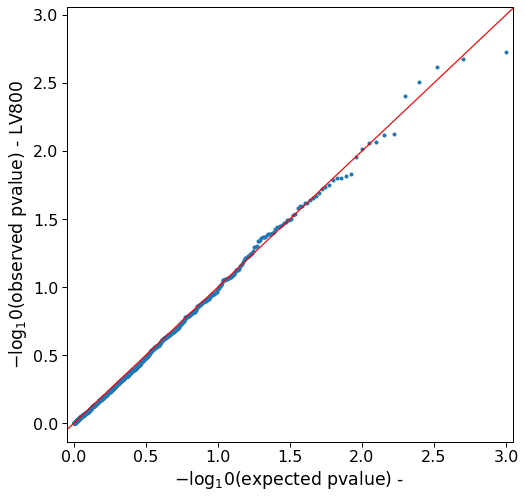

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
1,LV10,0.008,0.049,0.088
314,LV382,0.010,0.049,0.096
258,LV331,0.012,0.049,0.091
363,LV426,0.016,0.049,0.095
227,LV303,0.009,0.049,0.097
364,LV427,0.012,0.049,0.100
395,LV455,0.011,0.049,0.086
406,LV465,0.010,0.049,0.085
755,LV78,0.016,0.049,0.087
294,LV364,0.014,0.049,0.097


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.003830,0.010538,0.363450,0.716281,0.358140,random.pheno988
1398,LV412,-0.003483,0.010500,-0.331683,0.740140,0.629930,random.pheno589
2385,LV412,0.004033,0.010494,0.384285,0.700780,0.350390,random.pheno385
3372,LV412,-0.004071,0.010556,-0.385650,0.699769,0.650116,random.pheno5
4359,LV412,0.017185,0.010501,1.636477,0.101789,0.050894,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.013

In [100]:
show_prop(results, 0.05)

0.055

In [101]:
show_prop(results, 0.10)

0.102

In [102]:
show_prop(results, 0.15)

0.148

In [103]:
show_prop(results, 0.20)

0.196

### QQplot

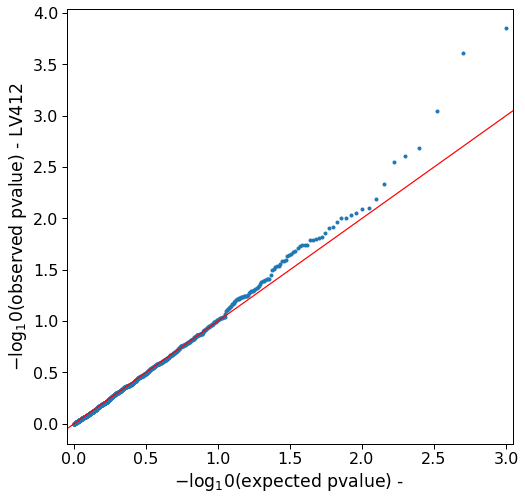

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020259,0.012369,-1.637878,0.101496,0.949252,random.pheno988
1043,LV57,0.016943,0.012383,1.368277,0.171273,0.085637,random.pheno589
2030,LV57,0.018694,0.012387,1.509139,0.131312,0.065656,random.pheno385
3017,LV57,0.001211,0.012372,0.097857,0.922049,0.461024,random.pheno5
4004,LV57,0.013373,0.012348,1.083061,0.278822,0.139411,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.01

In [111]:
show_prop(results, 0.05)

0.059

In [112]:
show_prop(results, 0.10)

0.109

In [113]:
show_prop(results, 0.15)

0.147

In [114]:
show_prop(results, 0.20)

0.186

### QQplot

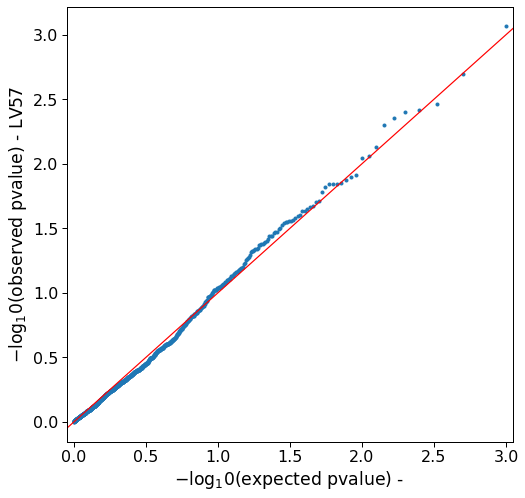

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.006307,0.011489,-0.548957,0.583054,0.708473,random.pheno988
1633,LV647,0.013764,0.011497,1.197237,0.231258,0.115629,random.pheno589
2620,LV647,0.011544,0.011496,1.004172,0.315333,0.157667,random.pheno385
3607,LV647,0.001850,0.011497,0.160931,0.872153,0.436076,random.pheno5
4594,LV647,0.014072,0.011468,1.227041,0.219852,0.109926,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.025

In [122]:
show_prop(results, 0.05)

0.071

In [123]:
show_prop(results, 0.10)

0.118

In [124]:
show_prop(results, 0.15)

0.168

In [125]:
show_prop(results, 0.20)

0.214

### QQplot

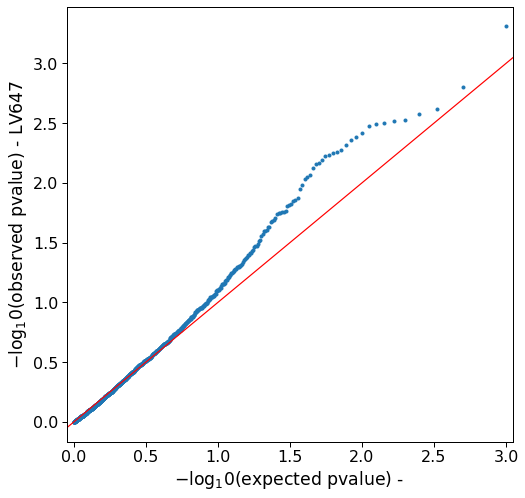

In [126]:
qqplot_unif(results)